<a href="https://colab.research.google.com/github/donCESAR12345/build-a-celestial-bodies-database/blob/master/Tarea_FIC(1%2C2%2C3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea Redes neuronales artificales (puntos 1, 2 y 3)

Presentado por:

Santiago Velez

CC
1214743044

Javier León

CC
1004215472

Para ver el desarrollo del punto 4 visitar:

https://colab.research.google.com/drive/1sMxfMZivaPdXTgPxBRhJgyfNuNAQGRrv?usp=sharing

## Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

## Carga de datos con drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Se cargan los datos
file_path = '/content/drive/MyDrive/Tarea_FIC/DatosconClases.xlsx'
df = pd.read_excel(file_path)

## Preparación de los datos trabajando con balance de carga y funciones para muestra de datos

In [ ]:
# se mezclan todas las muestras
df_mezclado = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Separar 80% para entrenamiento y 20% para prueba
total = len(df_mezclado)
indice_80 = int(0.8 * total)
# Se toma el 80% de los datos para entrenar
df_entrenamiento = df_mezclado.iloc[:indice_80].copy()
# Se toma el 20% de los datos para hacer pruebas
df_prueba = df_mezclado.iloc[indice_80:].copy()

# Contar clases en entrenamiento
columna_clase = "Clase Entrega 1"

# Selecciono todas las clases que sean aves y no aves
aves = df_entrenamiento[df_entrenamiento[columna_clase] == 2]
no_aves = df_entrenamiento[df_entrenamiento[columna_clase] == 1]

# Se calcula cuantas muestras de aves hacen falta para tener un buen balance de carga
faltantes = len(no_aves) - len(aves)

# Generar muestras sintéticas de aves con criterio ±0.001 ->
# Se selecciona solo las muestras para generar
caracteristicasAv = aves.iloc[:, :9].values

sinteticas = []
for i in range(faltantes):
    # tomo una muestra al azar de las que cumplen con ser aves
    muestra = caracteristicasAv[np.random.randint(0, len(caracteristicasAv))].copy()
    # se genera un numero al azar muy pequeño para generar una muestra parecida a la anterior
    ruido = np.random.uniform(-0.001, 0.001, size=muestra.shape)
    nueva_muestra = muestra + ruido
    # Agrego una muestra sintética
    sinteticas.append(nueva_muestra)

# Crear DataFrame de muestras sintéticas y sus respectivas etiquetas
df_sinteticas = pd.DataFrame(sinteticas, columns=aves.columns[:9])
df_sinteticas[columna_clase] = 2  # Clase de aves

# Dataset final balanceado
df_balanceado = pd.concat([no_aves, aves, df_sinteticas], ignore_index=True)
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)


# Guardar conjuntos si deseas
# df_balanceado.to_csv("datos_entrenamiento_balanceado.csv", index=False)
# df_prueba.to_csv("datos_prueba.csv", index=False)

# Se selecciona los datos para entrenar
data_entrenamiento = df_balanceado.iloc[:, 0:9].values
#Se selecciona la salida solo de la fila que es para este punto (Clase Entrega 1)
salida_entrenamiento = df_balanceado["Clase Entrega 1"].values
salida_entrenamiento = salida_entrenamiento-1
#Se normaliza para que cada caracteristica tenga igual importancia
data_entrenamiento = (data_entrenamiento - np.mean(data_entrenamiento, axis=0)) / np.std(data_entrenamiento, axis=0)
#data_entrenamiento_sin_bias = data_entrenamiento.copy()
#data_entre
data_entrenamientoPCM = data_entrenamiento.copy()

# Agregar columna de bias (valor constante = 1)
#data_entrenamiento = np.hstack((np.ones((data_entrenamiento.shape[0], 1)), data_entrenamiento))

# Se selecciona los datos para entrenar
data_test = df_prueba.iloc[:, 0:9].values


#Se selecciona la salida solo de la fila que es para este punto (Clase Entrega 1)
salida_test = df_prueba["Clase Entrega 1"].values
salida_test = salida_test-1
#Se normaliza para que cada caracteristica tenga igual importancia
data_test = (data_test - np.mean(data_test, axis=0)) / np.std(data_test, axis=0)
data_test_sin_bias = data_test.copy()
# Agregar columna de bias (valor constante = 1)
#data_test = np.hstack((np.ones((data_test.shape[0], 1)), data_test))

In [ ]:
def funcion_escalon(z):
  ## función de activación
  if z > 0:
    return 1
  elif z <= 0:
    return 0
def error_cuadratico_medio(Salida,Esperada):
  error2medio = pow((Salida-Esperada),2)/2
  return error2medio

In [ ]:
def crear_tabla(encabezados, datos):
    # Determinar el ancho máximo para cada columna
    anchos = []
    for i in range(len(encabezados)):
        # Longitud máxima entre los encabezados y los datos de cada columna
        max_ancho = max(len(str(encabezados[i])), max(len(str(fila[i])) for fila in datos))
        anchos.append(max_ancho + 2)  # +2 para espacio adicional

    # Imprimir encabezados
    for i in range(len(encabezados)):
        print(f"{encabezados[i]:<{anchos[i]}}", end="")
    print()  # Nueva línea

    # Línea separadora
    print("-" * sum(anchos))

    # Imprimir filas de datos
    for fila in datos:
        for i in range(len(fila)):
            print(f"{str(fila[i]):<{anchos[i]}}", end="")
        print()  # Nueva línea

def matriz_confusión(y_real, y_pred,TipoDato):
  # Supón que ya tienes y_real y y_pred
  cm = confusion_matrix(y_real.flatten(), y_pred)
  TN, FP, FN, TP = cm.ravel()
  Presicion = TP/(TP+FP)
  Sensibilidad = TP/(TP+FN)
  Especificidad = TN/(TN+FP)
  Exactitud = (TP+TN)/(TP+TN+FP+FN)
  F1 = 2 * (Presicion * Sensibilidad) / (Presicion + Sensibilidad)

  nombres_clases = ["No Aves", "Aves"]
  # Mostrar la matriz gráficamente
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nombres_clases)

  disp.plot(cmap="Blues")
  plt.title("Matriz de Confusión: datos de "+TipoDato)
  plt.show()
  return [round(Presicion,4), round(Sensibilidad,4), round(Especificidad,4), round(Exactitud,4), round(F1,4)]

### Funcion para evaluar perceptron

In [ ]:
def evaluar(Entradas,y,w,bias):
  bias = 0
  contadorCorrecto = 0
  contadorIncorrecto = 0
  Salida_Red = []
  for i in range(len(Entradas)):
    ## MULTIPLICACIÓN
    Salida = np.dot(Entradas[i], w) + bias
    SalidaC = 1 if Salida >=0 else 0
    Salida_Red.append(SalidaC)

    if SalidaC == y[i]:
      contadorCorrecto += 1
    else:
      contadorIncorrecto += 1
  Porcentaje_Incorrectos = round((contadorIncorrecto/len(Entradas))*100,3)
  Porcentaje_Correctos = round((contadorCorrecto/len(Entradas))*100,3)
  #print(Porcentaje_Incorrectos)

  return Porcentaje_Incorrectos, Salida_Red

### Preparación de los datos (Es la versión inicial de prueba sin balance de carga)

In [ ]:
x = df.iloc[:, 0:9].values
y = df["Clase Entrega 1"].values
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
x_sin_bias = x.copy()
x = np.hstack((np.ones((x.shape[0], 1)), x))

n_entrenamiento = 0.8
n_test = 1 - n_entrenamiento
indice = int(n_entrenamiento * len(x))

Epoca = 100
Tasa_aprendizaje = 0.1

data_entrenamiento1 = x[:indice]
data_test1 = x[indice:]

salida_entrenamiento1 = y[:indice]
salida_test1 = y[indice:]

# Punto 1
Implemente una red neuronal monocapa con algoritmo LMS, de tal manera que se diferencie entre aves y otras especies.

In [ ]:
def perceptron(Entradas,y):
  tasa_de_aprendizaje = 0.02
  No_caractersiticas = len(Entradas[0])
  w = np.zeros(No_caractersiticas)
  bias = 0
  error2M = []
  while True:
    errorEpoca = 0
    for i in range(len(Entradas)):
      Salida = np.dot(Entradas[i], w) + bias
      error = error_cuadratico_medio(y[i],Salida)
      errorEpoca += error
      error_pesos = y[i] - Salida
      w += tasa_de_aprendizaje * error_pesos * Entradas[i]
      bias += tasa_de_aprendizaje * error_pesos
    error2M.append(error)

    PE,LIST = evaluar(Entradas,y,w,bias)
    #print(PE)
    if PE <= 22:
      break
  return w, bias, error2M

In [ ]:
Salida_RED_Train = []
Salida_RED_Test = []
err2M = []
# Se entrena el modelo con los datos de entrada
pesos_perceptron, bias_perceptron, err2M = perceptron(data_entrenamiento,salida_entrenamiento)
# Se evalúa el error con los datos de entrenamiento
error_entrenamiento , Salida_RED_Train = evaluar(data_entrenamiento,salida_entrenamiento,pesos_perceptron,bias_perceptron)
#print("% error de entrenamiento: ",error_entrenamiento,"%")
# Se evalúa el error con los datos de prueba
error_prueba , Salida_RED_Test = evaluar(data_test,salida_test,pesos_perceptron,bias_perceptron)
#print("% error de prueba: ",error_prueba,"%")

## Error cuadrático medio de perceptron en cada iteración

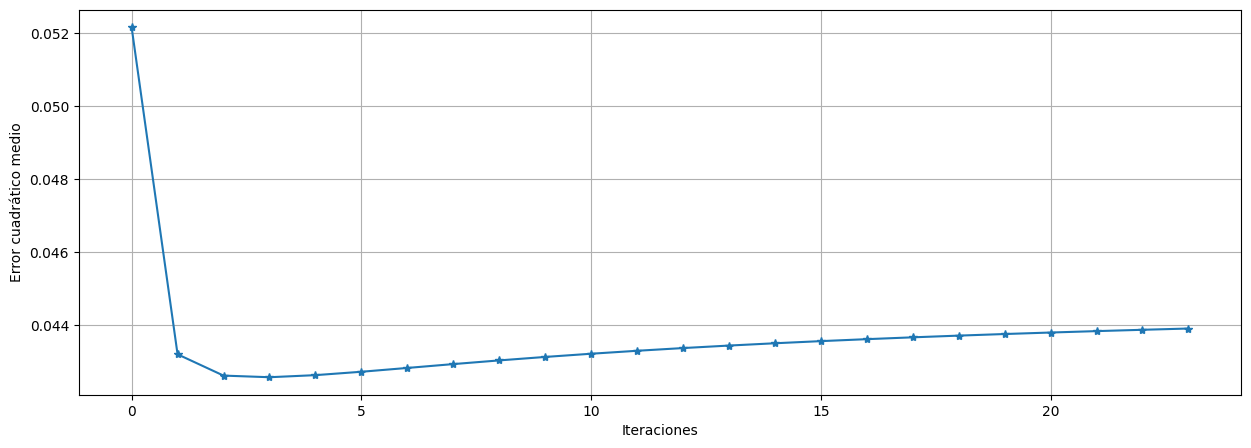

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(err2M,marker="*")
plt.grid()
plt.xlabel("Iteraciones")
plt.ylabel("Error cuadrático medio")
plt.show()

## Matriz de confusión y metricas para datos de entrenamiento Perceptron

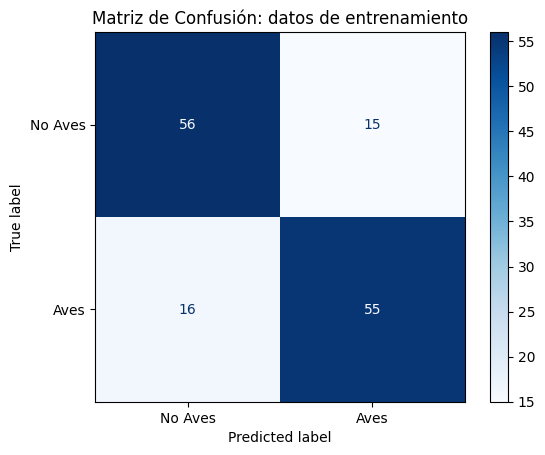

 
% Error_Train  Presicion  Sensibilidad  Especificidad  Exactitud  F1      
--------------------------------------------------------------------------
21.831         0.7857     0.7746        0.7887         0.7817     0.7801  


In [ ]:
Train = matriz_confusión(salida_entrenamiento,Salida_RED_Train,"entrenamiento")
print(" ")
Train.insert(0,error_entrenamiento)
encabezados = ["% Error_Train","Presicion", "Sensibilidad", "Especificidad", "Exactitud", "F1"]
datos = [Train]
crear_tabla(encabezados, datos)

## Matriz de confusión y metricas para los datos de prueba Perceptron

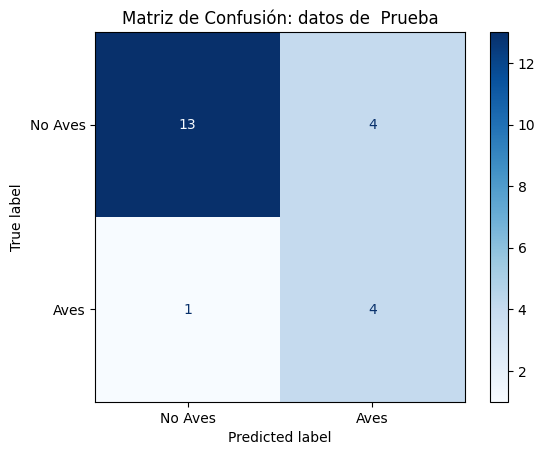

 
% Error_Test  Presicion  Sensibilidad  Especificidad  Exactitud  F1      
-------------------------------------------------------------------------
22.727        0.5        0.8           0.7647         0.7727     0.6154  


In [ ]:
Test = matriz_confusión(salida_test,Salida_RED_Test," Prueba")
Test.insert(0,error_prueba)
print(" ")
encabezados = ["% Error_Test","Presicion", "Sensibilidad", "Especificidad", "Exactitud", "F1"]
datos = [Test]
crear_tabla(encabezados, datos)

# Punto 2
Implemente una red neuronal monocapa con algoritmo de entrenamiento Perceptron (de
bolsillo), de tal manera que se diferencie entre aves y otras especies.

In [ ]:
def perceptron_bolsillo(Entradas,y):
  tasa_de_aprendizaje = 0.5
  No_caracteristicas = len(Entradas[0]) # Determino el número de caracteristicas
  w = np.zeros(No_caracteristicas) # Genero vector de los pesos iniciales aleatoramiente para la instancia inicial
  bias = 0
  evError = []
  while True:
    for i in range(len(Entradas)):
      ## MULTIPLICACIÓN
      valor = funcion_escalon(np.dot(Entradas[i],w))
      error = y[i] - valor
      if valor != y[i]:
        w = w + tasa_de_aprendizaje * error * Entradas[i]
        bias = bias + tasa_de_aprendizaje * error

    PE,LIST = evaluar(Entradas,y,w,bias)
    evError.append(PE)
    #print(PE)
    if PE <= 15:
      break

  return w,evError,bias

In [ ]:
Salida_RED_TrainPB = []
Salida_RED_TestPB = []
# Se entrena el modelo con los datos de entrada
pesos_perceptron_bolsillo , erro2m, bias_perceptron_bolsillo = perceptron_bolsillo(data_entrenamiento,salida_entrenamiento)
error_entrenamiento_bolsillo , Salida_RED_TrainPB = evaluar(data_entrenamiento,salida_entrenamiento,pesos_perceptron_bolsillo,bias_perceptron_bolsillo)
print("El porcentaje de error de entrenamiento es: ",error_entrenamiento_bolsillo,"%")
error_prueba_bolsillo , Salida_RED_TestPB = evaluar(data_test , salida_test , pesos_perceptron_bolsillo,bias_perceptron_bolsillo)
print("El porcentaje de error de prueba es: ",error_prueba_bolsillo,"%")

El porcentaje de error de entrenamiento es:  14.085 %
El porcentaje de error de prueba es:  22.727 %


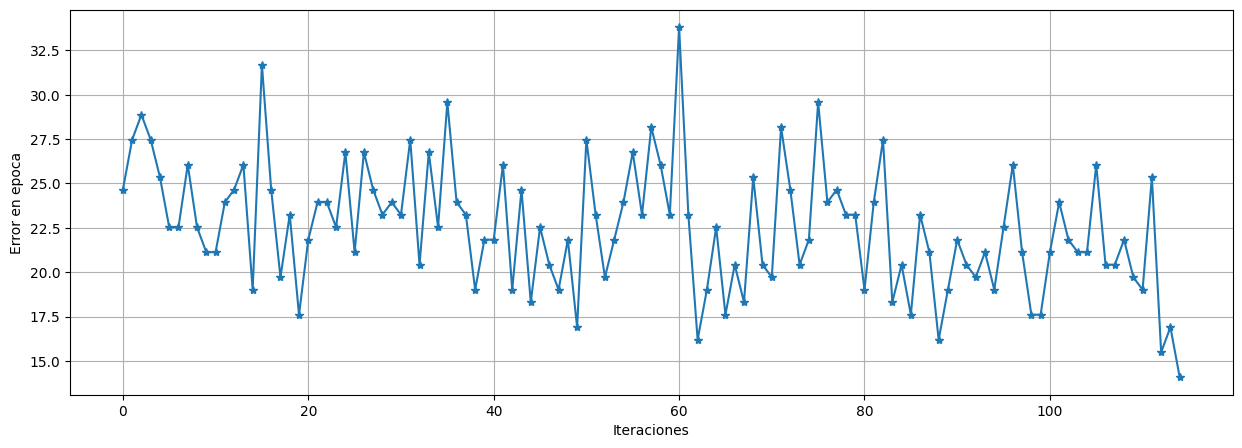

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(erro2m,marker="*")
plt.grid()
plt.xlabel("Iteraciones")
plt.ylabel("Error en epoca")
plt.show()

## Matriz de confusión y metricas para datos de entrenamiento Perceptron de bolsillo

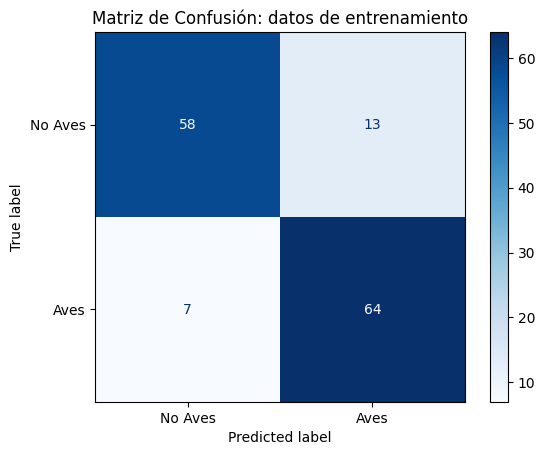

 
% Error_Train  Presicion  Sensibilidad  Especificidad  Exactitud  F1      
--------------------------------------------------------------------------
14.085         0.8312     0.9014        0.8169         0.8592     0.8649  


In [ ]:
Train = matriz_confusión(salida_entrenamiento,Salida_RED_TrainPB,"entrenamiento")
print(" ")
Train.insert(0,error_entrenamiento_bolsillo)
encabezados = ["% Error_Train","Presicion", "Sensibilidad", "Especificidad", "Exactitud", "F1"]
datos = [Train]
crear_tabla(encabezados, datos)

## Matriz de confusión y metricas para datos de entrenamiento Perceptron de bolsillo

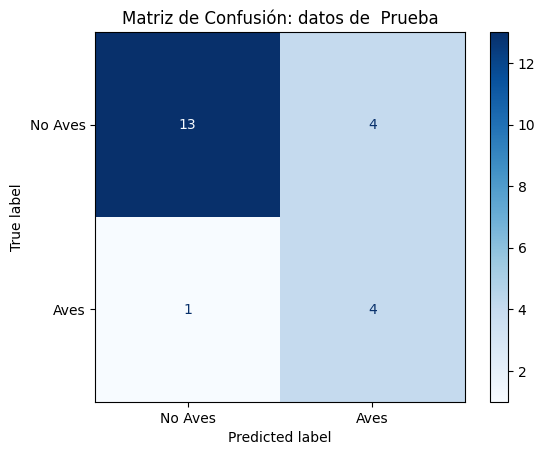

 
% Error_Test  Presicion  Sensibilidad  Especificidad  Exactitud  F1      
-------------------------------------------------------------------------
22.727        0.5        0.8           0.7647         0.7727     0.6154  


In [ ]:
Test = matriz_confusión(salida_test,Salida_RED_TestPB," Prueba")
Test.insert(0,error_prueba_bolsillo)
print(" ")
encabezados = ["% Error_Test","Presicion", "Sensibilidad", "Especificidad", "Exactitud", "F1"]
datos = [Test]
crear_tabla(encabezados, datos)

### Función para validar comportamiento (no se hace backpropagation)

Con los datos de prueba

# Punto 3
Implemente una red neuronal tipo Perceptron multicapa, con algoritmo de entrenamiento back- propagation, de tal manera que la red diferencie entre aves y otras especies. Usted decide si usa tasa de aprendizaje variable o fija.

### Funciones para perceptron multicapa

In [ ]:
def generate_random_matrix(x, y):
  return np.random.rand(x, y)
  #return np.zeros(x,y)

def regla_delta(salida,funcion_error,tasa_de_aprendizaje):
  Pesos = -(tasa_de_aprendizaje*funcion_error*salida)
  return Pesos

def regla_delta_co(salida,funcion_error,tasa_de_aprendizaje):
  Pesos = -tasa_de_aprendizaje * (salida * funcion_error)
  return Pesos

def funcion_sigmoide(x):
  funcion_sig =  1 / (1 + np.exp(-x))
  return funcion_sig

# Se usa para la capa final (segunda derivada de sigmoide)
def funcion_error(predicho,esperado):
  # Delta se entiende como la el error cometido por la neurona en cuestión
  delta = (predicho - esperado) * funcion_error_co(predicho)
  return delta

# Se usa para las capas ocultas (primera derivada de sigmoide)
def funcion_error_co(predicho):
  # Delta se entiende como la el error cometido por la neurona en cuestión
  delta = predicho * (1 - predicho)
  return delta

def funcion_propagacion_co(x_co,delta_s,w_s):
  delta = np.dot(np.transpose(w_s), delta_s) * x_co * (1 - x_co)
  return delta

def relu(z):
    return np.maximum(0, z)

def relu_derivative(a):  # a = relu(z)
    return (a > 0).astype(float)

def funcion_escalon_vector(vector):
    """Función escalón aplicada a un vector.
       Devuelve 1 si el elemento es >= 0, 0 en otro caso.
    """
    return np.where(vector >= 0, 1, 0)

### Funcion para evaluar multicapa

In [ ]:
def evaluar_multicapa(datos_prueba, salidas, pesos_capaOC, BIAS, w_salida, bias_salida):
    predicciones = []
    contadorCorrecto = 0
    contadorIncorrecto = 0
    Salida_Red = []
    for i in range(len(datos_prueba)):
      # Forwarding
      Entrada = datos_prueba[i]
      for index in range(len(pesos_capaOC)):
        Entrada = np.dot(Entrada, pesos_capaOC[index].T) + BIAS[index]
        Entrada = relu(Entrada)
        #Entrada = funcion_sigmoide(Entrada)  #TENER EN CUENTA CON CUAL DE LAS DOS

      # Capa de salida
      SalidaFinal = funcion_sigmoide(np.dot(Entrada, w_salida.T) + bias_salida)
      #print("Se predijo: ",SalidaFinal," Se esperaba: ",salidas[i])
      SalidaC = 1 if SalidaFinal > 0.5 else 0
      Salida_Red.append(SalidaC)
      #print(SalidaC)
      if SalidaC == salidas[i]:
        contadorCorrecto += 1
      else:
        contadorIncorrecto += 1
    Porcentaje_Incorrectos = (contadorIncorrecto/len(datos_prueba))*100

      #print(Porcentaje_Incorrectos)
    return Porcentaje_Incorrectos, Salida_Red

### Perceptron con backpropagation

In [ ]:
#from copy import Error
Capas_oc = [7,5,3]
Tasa_aprendizaje = 0.01
# Instanciar los primeros pesos
#data_entrenamientoPCM = data_entrenamiento1
#salida_entrenamiento = salida_entrenamiento1
Primer_ENTRADA = len(data_entrenamiento[0])

Entradas_CO = []

w_salida = generate_random_matrix(1,Capas_oc[-1]) #* 0.001
bias_salida = np.zeros(1) # formato (1,)
pesos_capaOC = []
BIAS = []

# SOLO SE USA UNA VEZ, se generan pesos iniciales y bias inciales
for index in range(len(Capas_oc)):
  No_neuronasPorCapa = Capas_oc[index]
  No_EntradasPorCapa = Capas_oc[index-1]
  if index == 0:
    # Tendrán el tamaño de (# de nueronas capa, #cantidad de entradas que le llegan a la neurona)
    MatrizPesos_porCapa = generate_random_matrix(No_neuronasPorCapa,Primer_ENTRADA) * np.sqrt(2 / Primer_ENTRADA) #Inicialización Xavier/Gold
  else:
    MatrizPesos_porCapa = generate_random_matrix(No_neuronasPorCapa,No_EntradasPorCapa)  * np.sqrt(2 / No_EntradasPorCapa)

  pesos_capaOC.append(MatrizPesos_porCapa.copy())
  tamaño_bias = pesos_capaOC[index].shape[0]
  bias_oculto = np.zeros(tamaño_bias)
  BIAS.append(bias_oculto.copy()) # tiene formato (x,)

 ####################################################################### PROCESO DE ENTRENAMIENTO #######################################################################
ErroresDeEpoca = []
while True:
  ErrorPorEpoca = 0
  #len(data_entrenamientoPCM)
  for i in range(len(data_entrenamiento)):
    ErrorPorMuestra = 0
    Entrada = data_entrenamiento[i]
    Entradas_CO = []
    Entradas_CO_reLU = []
    Entradas_CO.append(Entrada)
    Entradas_CO_reLU.append(Entrada)
    # AQUI EMPIEZA FORWARDING
    for index in range(len(pesos_capaOC)):
      #Entrada = funcion_sigmoide(np.dot(Entrada, pesos_capaOC[index].T) + BIAS[index]) # Para las capas ocultas con sigmoide
      Entrada = relu(np.dot(Entrada, pesos_capaOC[index].T) + BIAS[index])
      Entradas_CO.append(Entrada)
      Entradas_CO_reLU.append(Entrada)

    #### PROCEDIMIENTO SOLO PARA LA SALIDA #####
    Salida = funcion_sigmoide(np.dot(Entrada, w_salida.T) + bias_salida)
    gradiente_CS = funcion_error(Salida, salida_entrenamiento[i])
    gradiente_CO = gradiente_CS.copy()

    # Calculo de error cuadrático medio
    ErrorPorMuestra += error_cuadratico_medio(Salida,salida_entrenamiento[i])

    pesos_capaOC.append(w_salida) ### PROVISIONAL
    Entradas_CO.append(Salida)
    Entradas_CO_reLU.append(Salida)
    BIAS.append(bias_salida) ### PROVISIONAL

    ## AQUI EMPIEZA BACKPROPAGATION
    pesos_capaOC = pesos_capaOC[::-1]
    Entradas_CO = Entradas_CO[::-1]
    Entradas_CO_reLU = Entradas_CO_reLU[::-1]
    BIAS = BIAS[::-1]

    gradientes_CO = []
    gradientes_CO.append(gradiente_CO)

    # Calculo de los gradientes
    for capa in range(len(pesos_capaOC)):
      #gradiente_CO = np.dot(pesos_capaOC[capa].T , gradiente_CO) * funcion_error_co(Entradas_CO[capa+1]) #Para hacerlo con sigmoide en capas ocultas
      gradiente_CO = np.dot(pesos_capaOC[capa].T , gradiente_CO) * funcion_escalon_vector(Entradas_CO_reLU[capa+1])
      gradientes_CO.append(gradiente_CO)

    # Actualización de los pesos
    for capas in range(len(pesos_capaOC)):
      #cambio = Tasa_aprendizaje * (gradientes_CO[capas].reshape(-1,1) @ Entradas_CO[capas+1].reshape(-1,1).T)
      cambio = Tasa_aprendizaje * (gradientes_CO[capas].reshape(-1,1) @ Entradas_CO_reLU[capas+1].reshape(-1,1).T)
      pesos_capaOC[capas] = pesos_capaOC[capas] - cambio

    # ACtualización de los BIAS
    for capas in range(len(BIAS)):
      BIAS[capas] = BIAS[capas] - Tasa_aprendizaje * gradientes_CO[capas]

    BIAS = BIAS[::-1]
    pesos_capaOC = pesos_capaOC[::-1]
    bias_salida = BIAS.pop()
    w_salida = pesos_capaOC.pop()

    ErrorPorEpoca += ErrorPorMuestra
  ErrorPorEpoca = ErrorPorEpoca / len(data_entrenamiento)
  ErroresDeEpoca.append(ErrorPorEpoca)
  PE,SL = evaluar_multicapa(data_entrenamiento,salida_entrenamiento,pesos_capaOC,BIAS,w_salida,bias_salida)
  #print(PE)
  if PE < 16:
    #print(PE)
    break
  #Tasa_aprendizaje = 1/(1+0.001*iteraciones)
  #print("Error por epoca: ",ErrorPorEpoca)


error_entrenamiento_PML,Salida_RED_TrainPML = evaluar_multicapa(data_entrenamiento,salida_entrenamiento,pesos_capaOC,BIAS,w_salida,bias_salida)
#print(error_entrenamiento_PML)
print("El error de entrenamiento es de: ",error_entrenamiento_PML,"%")
error_prueba_PML,Salida_RED_TestPML = evaluar_multicapa(data_test,salida_test,pesos_capaOC,BIAS,w_salida,bias_salida)
print("El error de prueba es de: ",error_prueba_PML,"%")

El error de entrenamiento es de:  15.492957746478872 %
El error de prueba es de:  22.727272727272727 %


### Evolución del error en cada época

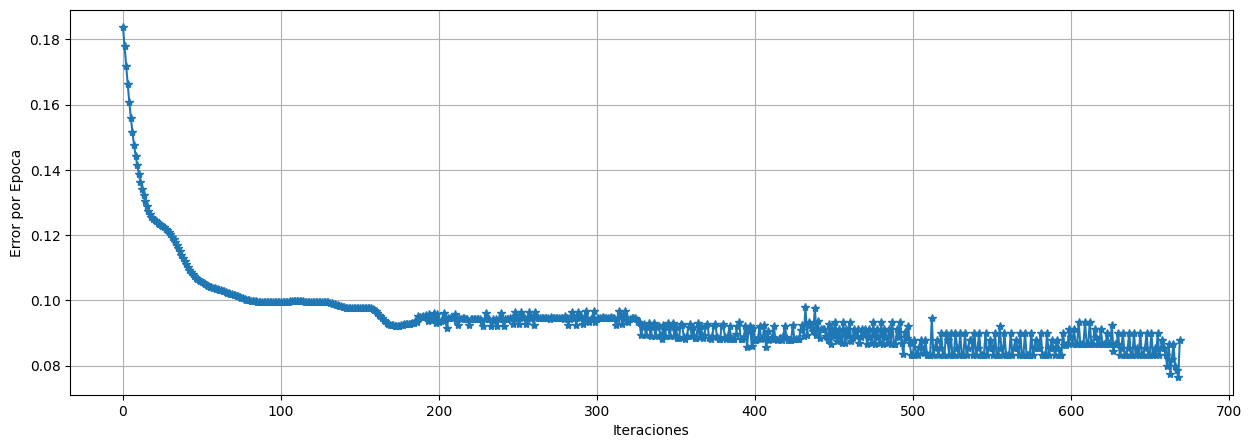

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ErroresDeEpoca,marker="*")
plt.grid()
plt.xlabel("Iteraciones")
plt.ylabel("Error por Epoca")
plt.show()

### Matriz de confusión para datos de entrenamiento

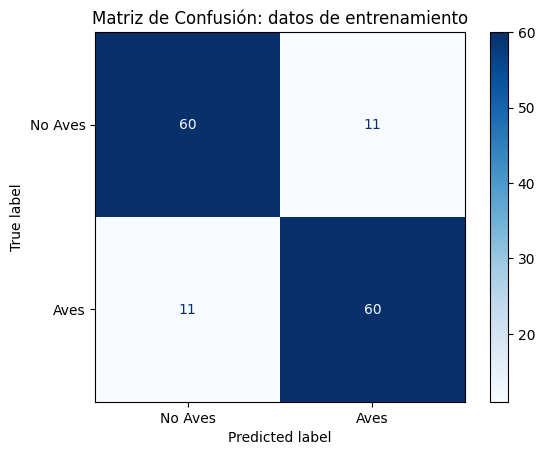

 
% Error_Train       Presicion  Sensibilidad  Especificidad  Exactitud  F1      
-------------------------------------------------------------------------------
15.492957746478872  0.8451     0.8451        0.8451         0.8451     0.8451  


In [ ]:
Train = matriz_confusión(salida_entrenamiento,Salida_RED_TrainPML,"entrenamiento")
print(" ")
Train.insert(0,error_entrenamiento_PML)
encabezados = ["% Error_Train","Presicion", "Sensibilidad", "Especificidad", "Exactitud", "F1"]
datos = [Train]
crear_tabla(encabezados, datos)

### Matriz de confusión para datos de prueba

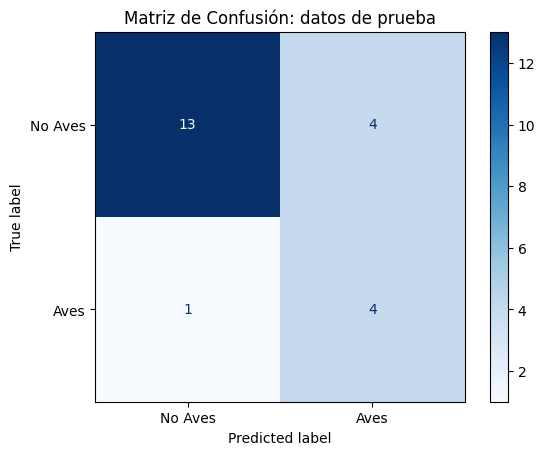

 
% Error_Train       Presicion  Sensibilidad  Especificidad  Exactitud  F1      
-------------------------------------------------------------------------------
22.727272727272727  0.5        0.8           0.7647         0.7727     0.6154  


In [ ]:
Train = matriz_confusión(salida_test,Salida_RED_TestPML,"prueba")
print(" ")
Train.insert(0,error_prueba_PML)
encabezados = ["% Error_Train","Presicion", "Sensibilidad", "Especificidad", "Exactitud", "F1"]
datos = [Train]
crear_tabla(encabezados, datos)

# Punto 4